In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import sklearn
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("tic-tac-toe.data.txt", sep=',', names = list(range(9)) + ['target'])
df.head()

,0,1,2,3,4,5,6,7,8,target
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [3]:
import copy

def dummy_encode_categorical_columns(data):
    result_data = copy.deepcopy(data)
    for column in data.columns.values:
        result_data = pd.concat([result_data, pd.get_dummies(result_data[column], prefix = column, prefix_sep = '_')], axis = 1)
        del result_data[column]
     
    return result_data

In [4]:
df = dummy_encode_categorical_columns(df)
df['target'] = df['target_positive']
df = df.drop(['target_positive', 'target_negative'], axis=1)
df.head()

,0_b,0_o,0_x,1_b,1_o,1_x,2_b,2_o,2_x,3_b,...,6_b,6_o,6_x,7_b,7_o,7_x,8_b,8_o,8_x,target
0,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,1,0,0,1,0,1
1,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,1,0,1
2,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,1,0,0,0,1,1
3,0,0,1,0,0,1,0,0,1,0,...,0,1,0,1,0,0,1,0,0,1
4,0,0,1,0,0,1,0,0,1,0,...,1,0,0,0,1,0,1,0,0,1


In [23]:
X, y = df.drop(['target'], axis=1), df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
positive_context = np.array(X_train[y_train == 1], dtype=int)
negative_context = np.array(X_train[y_train == 0], dtype=int)

In [25]:
def average_closure(x, context):
    closure_total = 0
    
    for x_train in context:
        intersection = (x == x_train)
        closure_total += np.sum(np.all(x[intersection] == context[:, intersection], axis=1))
        
    average_closure = closure_total / context.shape[0]
    
    return average_closure

In [26]:
def average_intersection(x, context):
    return np.mean([np.sum(x == x_train) for x_train in context])

In [27]:
def predict(x, params):
    positive_score = average_closure(x, positive_context)
    negative_score = average_closure(x, negative_context)
    
    if positive_score > params['coeff'] * negative_score:
        return 1
    else:
        return 0

In [28]:
predictions = [predict(np.array(x[1]), {'coeff': 1}) for x in X_test.iterrows()]

In [29]:
def get_scores(y_true, predictions):
    accuracy = sklearn.metrics.accuracy_score(y_true, predictions)
    precision = sklearn.metrics.precision_score(y_true, predictions)
    recall = sklearn.metrics.recall_score(y_true, predictions)
    f1 = sklearn.metrics.f1_score(y_true, predictions)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'F1': f1
    }

In [30]:
get_scores(y_test, predictions)

{'accuracy': 0.6041666666666666,
 'precision': 0.6041666666666666,
 'recall': 1.0,
 'F1': 0.7532467532467533}

# Cross val

In [31]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, ShuffleSplit

In [43]:
class LazyFcaPredictor:
    def __init__(self, params):
        self.params = params
        
    
    def fit(self, X_train, y_train):
        self.positive_context = np.array(X_train[y_train == 1])
        self.negative_context = np.array(X_train[y_train == 0])
        
    
    def predict(self, X_test):
        return [self.__predict_impl(X_test[i]) for i in range(X_test.shape[0])]
    
    
    def __predict_impl(self, x):
        positive_score = self.__average_closure(x, self.positive_context)
        negative_score = self.__average_closure(x, self.negative_context)
    
        if positive_score > self.params['coeff'] * negative_score:
            return 1
        else:
            return 0
        
    
    def __average_closure(self, x, X_train):
        closure_total = 0

        for x_train in X_train:
            intersection = (x == x_train)
            closure_total += np.sum(np.all(x[intersection] == X_train[:, intersection], axis=1))

        average_closure = closure_total / X_train.shape[0]

        return average_closure

In [44]:
clf = LazyFcaPredictor({'coeff': 1})

In [45]:
X = np.array(df.drop(['target'], axis=1))
y = np.array(df['target'])

In [46]:
kfold = ShuffleSplit(n_splits=4)

In [47]:
def get_avg_scores(threshold):
    f1 = []
    acc = []
    prec = []
    rec = []
    
    for train_ix, test_ix in kfold.split(X, y):
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]

        #print(X_train.shape)
        #print(y_train.shape)
        clf = LazyFcaPredictor({'coeff': threshold})
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        scores = get_scores(y_test, predictions)
        
        f1.append(scores['F1'])
        acc.append(scores['accuracy'])
        prec.append(scores['precision'])
        rec.append(scores['recall'])
    
    return np.mean(f1), np.mean(acc), np.mean(prec), np.mean(rec)

In [48]:
threshold_grid = np.arange(0.2, 3, 0.2)

accs = []
precs = []
recs = []
f1s = []

for threshold in tqdm(threshold_grid):
    f1, acc, prec, rec = get_avg_scores(threshold)
    
    f1s.append(f1)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)

 71%|███████▏  | 10/14 [02:21<00:56, 14.22s/it]/Users/nkarpachev/py3_rl/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nkarpachev/py3_rl/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████| 14/14 [03:20<00:00, 14.37s/it]


In [49]:
from matplotlib import pyplot as plt
%matplotlib inline

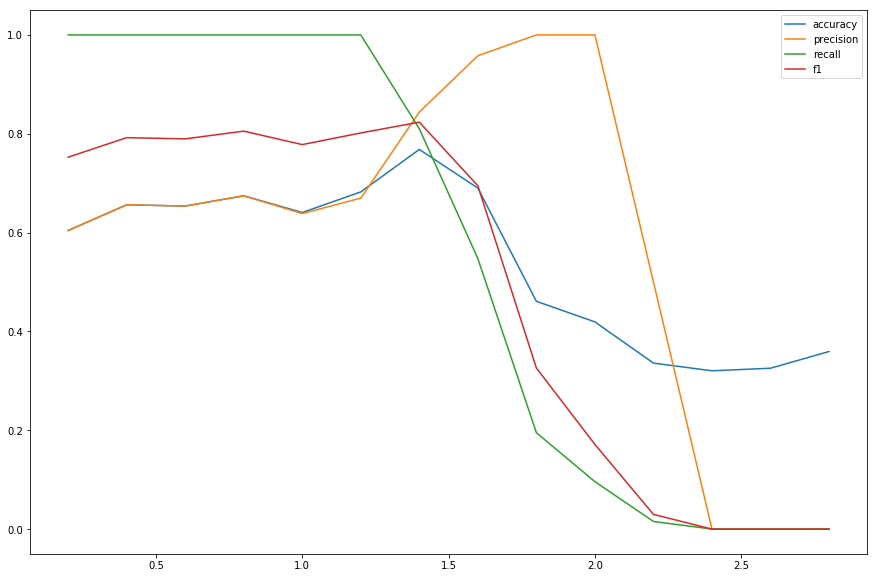

In [50]:
plt.figure(figsize=(15, 10))

plt.plot(threshold_grid, accs, label='accuracy')
plt.plot(threshold_grid, precs, label='precision')
plt.plot(threshold_grid, recs, label='recall')
plt.plot(threshold_grid, f1s, label='f1')

plt.legend()
plt.show()

# Use better models

In [58]:
def extract_features(x, positive_context, negative_context):
    return [
        average_closure(x, positive_context),
        average_closure(x, negative_context),
        average_intersection(x, positive_context),
        average_intersection(x, negative_context)
    ]

In [63]:
X = df.drop(['target'], axis=1)
y = df['target']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [65]:
features_train = np.array([extract_features(np.array(elem[1]), positive_context, negative_context) for 
                 elem in X_train.iterrows()])

In [66]:
features_test = np.array([extract_features(np.array(elem[1]), positive_context, negative_context) for 
                 elem in X_test.iterrows()])

In [67]:
from sklearn.linear_model import *
from sklearn.ensemble import RandomForestClassifier

In [68]:
clf = RandomForestClassifier()

clf.fit(features_train, np.array(y_train == 1))
pred = clf.predict(features_test)
get_scores(np.array(y_test == 1), pred)

/Users/nkarpachev/py3_rl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'accuracy': 0.9739583333333334,
 'precision': 0.9761904761904762,
 'recall': 0.984,
 'F1': 0.9800796812749003}

In [69]:
clf.feature_importances_

array([0.345512  , 0.49791167, 0.11124115, 0.04533519])

In [70]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()

clf.fit(features_train, np.array(y_train == 1))
pred = clf.predict(features_test)
get_scores(np.array(y_test == 1), pred)

{'accuracy': 0.921875,
 'precision': 0.9583333333333334,
 'recall': 0.92,
 'F1': 0.9387755102040817}